<a href="https://colab.research.google.com/github/dvircohen0/NLP/blob/main/decoder_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import string
import random
import re
import numpy as np
import json 
import os
import requests
import matplotlib.pyplot as plt



def random_dna_string_to_map():
    dna=list(string.ascii_lowercase)
    random_dna=list(dna)
    random.shuffle(random_dna)
    the_map ={}
    for i,j in zip(dna,random_dna):
         the_map[i] = j
    return the_map
       

def encode_msg(msg, true_map):
    encoded_msg =[]
    for ch in msg:
        encoded_ch = ch
        if ch in true_map:
            encoded_ch = true_map[ch]
        encoded_msg.append(encoded_ch)
    return ''.join(encoded_msg)

def decode_msg(msg, a_map):
    decoded_msg =[]
    a_map=dict((v,k) for k, v in a_map.items())
    for ch in msg:
        decoded_ch = ch
        if ch in a_map:
            decoded_ch = a_map[ch]
        decoded_msg.append(decoded_ch)
    return ''.join(decoded_msg)


### the language model

letters=string.ascii_lowercase
dim=len(letters)
# initialize Markov matrix
bigram = np.ones((dim, dim))

# initial state distribution
unigram = np.zeros(dim)

# a function to update the Markov matrix
def update_transition(ch1, ch2):
  # ord('a') = 97, ord('b') = 98, ...
  i = letters.index(ch1)
  j = letters.index(ch2)
  bigram[i,j] += 1

# a function to update the initial state distribution
def update_unigram(ch):
  i = letters.index(ch)
  unigram[i] += 1

# get the log-probability of a word / token
def get_word_prob(word):
  # print("word:", word)
  i = letters.index(word[0])
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = letters.index(ch)
    logp += np.log(bigram[i, j]) # update prob
    i = j # update j
  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp


# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_unigram(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
unigram /= unigram.sum()
bigram /= (bigram.sum(axis=1, keepdims=True) + 26)

In [31]:
original_msg ='''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''


original_msg = original_msg.rstrip()
original_msg=re.sub("[’]","",original_msg)
regex = re.compile('[^a-zA-Z]')
original_msg= regex.sub(" ",original_msg).lower()
original_msg=re.sub("\s\s+" , " ", original_msg)
true_map =random_dna_string_to_map()
encoded_msg = encode_msg(original_msg, true_map)

dna_pool = []
for _ in range(20):
    dna_pool.append(random_dna_string_to_map())

def evolve_ofspring(dna_pool, n_childeren):
    offspring = []
    for dna in dna_pool:
        for _ in range(n_childeren):
            copy = dna.copy()
            key1, key2 = random.sample(list(copy), 2)
            copy[key1], copy[key2] = copy[key2], copy[key1]
            offspring.append(copy)
    return dna_pool + offspring
            
num_itters = 1000
scores = np.zeros(num_itters)
best_dna = None
best_map = None
best_score = float('-inf')


for i in range(num_itters):
    if i > 0:
        dna_pool = evolve_ofspring(dna_pool, 3)
        
    dna2score = {}
    for dna in dna_pool:
        current_map = dna
        decoded_msg = decode_msg(encoded_msg, current_map)
        score = sentence_prob(decoded_msg,unigram,bigram)
        dna2score[str(current_map)] = score
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
            
    scores[i] = np.mean(list(dna2score.values()))
    sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse = True)
    dna_pool1 = sorted_dna [:5]
    dna_pool=[json.loads(dna_pool1[i][0].replace("\'", "\"")) for i in range(len(dna_pool1))]
    
    if i % 200 == 0:
        print("itter: ", i , " score:", scores[i], "best so far:", best_score)

itter:  0  score: -2088.0586255029193 best so far: -1698.9771817047524
itter:  200  score: -1029.0689419456746 best so far: -940.5149309617009
itter:  400  score: -1002.6153427755011 best so far: -929.8602611042709
itter:  600  score: -1037.1627409961955 best so far: -929.8602611042709
itter:  800  score: -1026.074491461662 best so far: -929.8602611042709


In [46]:
decoded_msg = decode_msg(encoded_msg, best_map)
print("score for beat map: ",sentence_prob(decoded_msg,unigram,bigram))
print("score for originl massage: ",sentence_prob(original_msg,unigram,bigram))

for key, v in true_map.items():
  pred = best_map[key]
  if v != pred:
    print("true map for %s: %s, pred: %s" % (key, v, pred))


# print the final decoded message
print("Decoded message:\n", decoded_msg)

print("\nTrue message:\n", original_msg)

score for beat map:  -929.8602611042709
score for originl massage:  -933.3362360694747
true map for j: r, pred: e
true map for k: w, pred: t
true map for q: e, pred: r
true map for z: t, pred: w
Decoded message:
 i then lounged down the street and found as i expected that there was a mews in a lane which runs down by one wall of the garden i lent the ostlers a hand in rubbing down their horses and received in exchange twopence a glass of half and half two fills of shag tobacco and as much information as i could desire about miss adler to say nothing of half a doken other people in the neighbourhood in whom i was not in the least interested but whose biographies i was compelled to listen to 

True message:
 i then lounged down the street and found as i expected that there was a mews in a lane which runs down by one wall of the garden i lent the ostlers a hand in rubbing down their horses and received in exchange twopence a glass of half and half two fills of shag tobacco and as much inf

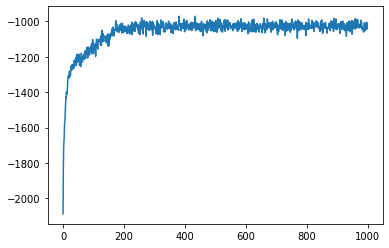

In [49]:
plt.plot(scores)
plt.show()